# 4. Анализ результатов A/B-тестирования: кумулятивные метрики

### ОПИСАНИЕ ЗАДАЧИ

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

    Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
    Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.

Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

    Контрольной (группе А) доступен первый вариант рекомендаций.
    Тестовой (группе B) доступен второй вариант. 

Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

In [1]:
# импорт библиотек для работы с данными

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# импорт библиотеки для анализа

ab_data = pd.read_csv('data/ab_data.csv')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Итак, мы получили таблицу со следующими полями:

user_id 	идентификатор пользователя, зашедшего на сайт
timestamp 	дата события
group 	группа теста (контрольная или тестовая)
converted 	совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [5]:
# перевод времени в формат datetime

ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [6]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [7]:
# расчет конверсии

daily_data['conversion'] = daily_data['converted']/daily_data['users_count'] * 100
print(round(daily_data[
    (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
]['conversion'], 2))
display(daily_data.head())

6    12.32
Name: conversion, dtype: float64


,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


## ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

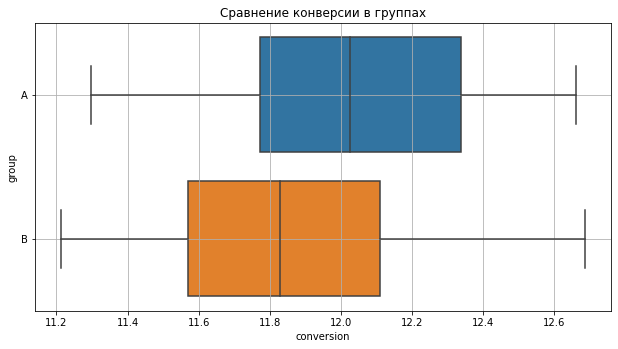

In [8]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [9]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

?Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

## КУМУЛЯТИВНЫЕ МЕТРИКИ

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

Примечание. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

#### Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

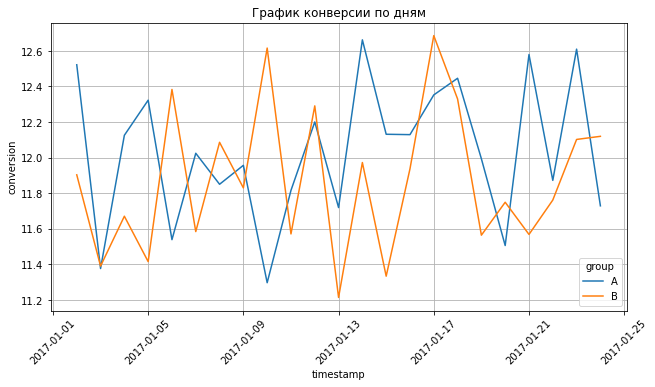

In [10]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [11]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

/home/alexandr/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Кумулятивную сумму можно записать в виде рекурсивной формулы: St = St-1 + Xt

    Xt — значение показателя в день ;
    St — значение суммы в день .

?Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [12]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


### А теперь построим графики кумулятивной конверсии по дням в каждой группе:

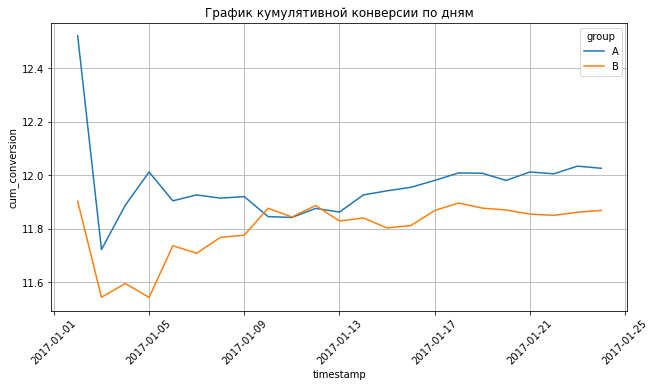

In [13]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

In [14]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [15]:
sample_a.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


In [16]:
sample_b.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


In [19]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

In [25]:
# группирование двух таблиц
sample = pd.concat([sample_a, sample_b])

In [26]:
sample.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


In [35]:
# формирование новых столбцов через аггрегирование
sample = sample.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue': 'sum'
}).reset_index().rename(columns={'cid': 'users_count','transactions': 'sum_tran', 'revenue': 'sum_bye'})
sample.head()

,date,group,users_count,sum_tran,sum_bye
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051


In [39]:
sample[sample['date'] == '2020-11-08']

,date,group,users_count,sum_tran,sum_bye
4,2020-11-08,A,3354,25,846051
5,2020-11-08,B,3291,24,3044842


In [44]:
# считаем кумулятивное показатели
sample.loc[:, 'cum_users_count'] = sample['users_count'].cumsum()
sample.loc[:, 'cum_sum_tran'] = sample['sum_tran'].cumsum()
sample.loc[:, 'cum_sum_bye'] = sample['sum_bye'].cumsum()
sample['conversion'] = sample['sum_tran']/sample['users_count'] * 100
sample.head()

,date,group,users_count,sum_tran,sum_bye,cum_users_count,cum_sum_tran,cum_sum_bye,conversion
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118
1,2020-11-06,B,2499,19,996645,5075,35,2573924,0.760304
2,2020-11-07,A,2704,23,1721886,7779,58,4295810,0.850592
3,2020-11-07,B,2804,19,555499,10583,77,4851309,0.677603
4,2020-11-08,A,3354,25,846051,13937,102,5697360,0.745379


In [46]:
# вычисляем кумулятивную сумму количества посетителей
sample['cum_users_count'] = sample.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
sample['cum_converted'] = sample.groupby(['group'])['sum_tran'].cumsum()
# вычисляем кумулятивную конверсию
sample['cum_conversion'] = sample['cum_converted']/sample['cum_users_count'] * 100
sample['cum_chek'] = sample['cum_sum_bye']/sample['cum_sum_tran']
display(sample.head())

,date,group,users_count,sum_tran,sum_bye,cum_users_count,cum_sum_tran,cum_sum_bye,conversion,cum_converted,cum_conversion,cum_chek
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,16,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,35,2573924,0.760304,19,0.760304,73540.685714
2,2020-11-07,A,2704,23,1721886,5280,58,4295810,0.850592,39,0.738636,74065.689655
3,2020-11-07,B,2804,19,555499,5303,77,4851309,0.677603,38,0.716576,63004.012987
4,2020-11-08,A,3354,25,846051,8634,102,5697360,0.745379,64,0.741256,55856.470588


In [50]:
#print(round(sample[sample['cum_conversion'] & sample['group']=='A'].mean(), 2))

sample[sample['group'] == 'A']['cum_conversion'].mean(), \
sample[sample['group'] == 'B']['cum_conversion'].mean()


(0.7127554606160046, 0.7621783890588012)

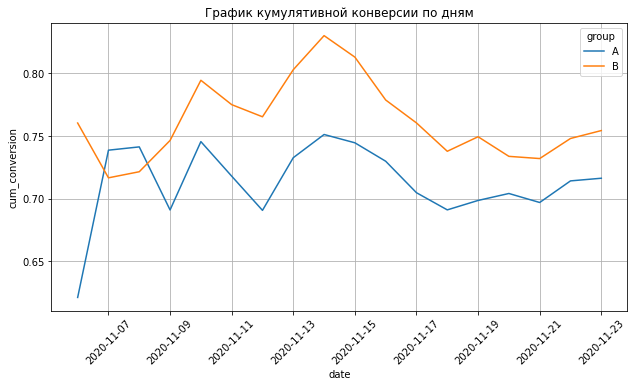

In [51]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=sample, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

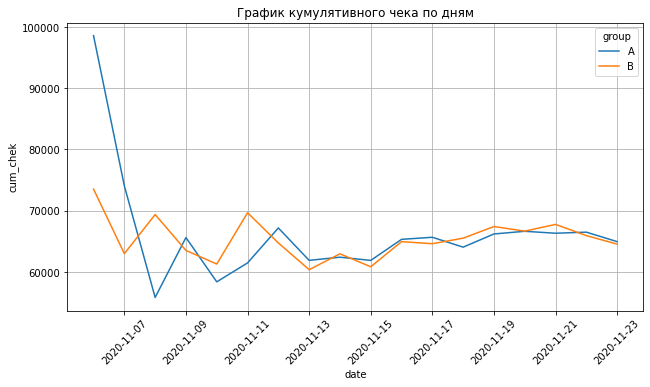

In [52]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_chek', data=sample, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);